In [164]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.special import eval_chebyt, gamma, factorial
from scipy.stats import argus
from scipy.integrate import quad
from numpy import  log, sqrt, exp, pi, e
import pyroot

In [165]:
gaussian = lambda x, mu, sigma: 1/(sigma) * np.exp(-(x-mu)**2/(2*sigma**2))

In [166]:
def nois_log(x, d):
    return np.heaviside(x-d, 1)*np.log(x)

In [167]:
def puasson(x, n):
    return np.exp(-x)*np.power(x, n)/gamma(n)

In [168]:
def normalization(counts, bin_edges):
    total_counts = np.sum(counts)
    bin_width = bin_edges[1] - bin_edges[0]
    return bin_width * total_counts 

In [169]:
def max_lik(f, x, x0, h = 1e-7):
    likelihood = lambda *args: np.log(f(*args))
    df = lambda args: np.linalg.norm(-np.sum(np.array([np.array([likelihood(j, *args[:i-1], args[i]+h, *args[i:]) - likelihood(j, *args[:i-1], args[i], *args[i:]) for j in x])/h
                                 if i != 0 else np.array([likelihood(j, args[i]+h, *args[i+1:]) - likelihood(j, args[i], *args[i+1:]) for j in x]) for i in range(len(x0))])/h, axis = 1))
    kkk = lambda *args: [[*args[:i-1], args[i]+h, *args[i:]] if i != 0 else [args[i]+h, *args[i+1:]] for i in range(len(x0))]
    print(minimize(df, x0))
    

In [170]:
def max_bin_lik(f, bin_centers, counts, args0, des = False, norm = False, h = 1e-7, bounds = None, normm = None, method='Nelder-Mead'):
    likelihoodn = lambda x, n, norm, *args: np.log(puasson(f(x, *args)/norm, n))
    likelihood = lambda x, n, *args: np.log(puasson(f(x, *args), n))
    if des:
        if norm:
            def df(args0, bin_centers, counts): 
                normf = np.sum(np.array([f(x, *args0) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
                return -np.sum(np.array([likelihoodn(x, n, normf, *args0) for x, n in zip(bin_centers, counts)]))
        else:
            df = lambda args0, bin_centers, counts: -np.sum(np.array([likelihood(x, n, *args0) for x, n in zip(bin_centers, counts)]))
    else:
        norm = sum(counts)*(bin_centers[1] - bin_centers[0])
        if norm:
            def df (args0, bin_centers, counts):
                normf = np.sum(np.array([f(x, *args0) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
                return  -np.sum(np.array([likelihoodn(x, n/norm, normf, *args0) for x, n in zip(bin_centers, counts)]))
        else:
            df = lambda args0, bin_centers, counts: -np.sum(np.array([likelihood(x, n/norm, *args0) if n !=0 else 0 for x, n in zip(bin_centers, counts)]))
    rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
    normf = np.sum(np.array([f(x, *rez.x) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
    print(rez)
    if normm == None:
        return rez.x, normf
    return rez.x, normf

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 57.19122297748936
             x: [ 9.971e-01  7.945e+00  2.029e+00  1.115e+00  6.937e-01]
           nit: 338
          nfev: 560
 final_simplex: (array([[ 9.971e-01,  7.945e+00, ...,  1.115e+00,
                         6.937e-01],
                       [ 9.971e-01,  7.945e+00, ...,  1.115e+00,
                         6.937e-01],
                       ...,
                       [ 9.971e-01,  7.945e+00, ...,  1.115e+00,
                         6.937e-01],
                       [ 9.971e-01,  7.945e+00, ...,  1.115e+00,
                         6.937e-01]]), array([ 5.719e+01,  5.719e+01,  5.719e+01,  5.719e+01,
                        5.719e+01,  5.719e+01]))


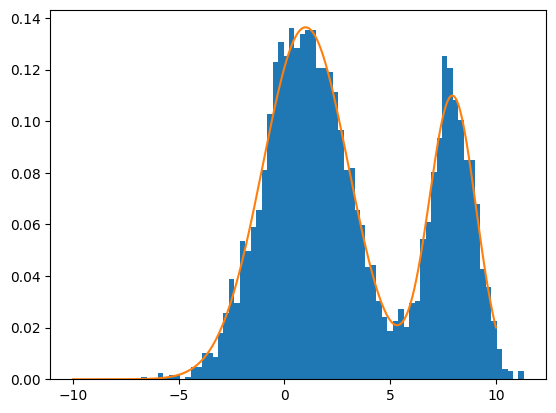

In [171]:
N = 5000
tau = 0.3
x = np.concatenate((np.random.normal(8, 1, int(N*tau)), np.random.normal(1, 2, int(N*(1-tau)))))
plt.hist(x, density=True, bins=70)
counts, bin_edges = np.histogram(x, bins=15)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
f = lambda x, mu1, mu2, s1, s2, tau: gaussian(x, mu1, s1)*tau + gaussian(x, mu2, s2)*(1-tau)
args, _ = max_bin_lik(f, bin_centers, counts, (1, 2, 1, 1, 0.5))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, [f(i, *args)/sqrt(2*pi) for i in xx])

In [172]:
lamc_mass = 2.28646
pi_mass = 0.135

In [173]:
fname = "root_/lam_mc.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
mc = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'tr_lamc', 'tr_ach', 'tr_p', 'npxc', 'mxc', 'chach', 'mach', 'chl', 'ml', 'pl', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2']


In [174]:
fname = "root_/lam_real.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
re = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'npxc', 'mxc', 'chach', 'mach', 'chl', 'ml', 'pl', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2']


In [161]:
data = [re, mc]

In [77]:
mc["chxc"] = pd.to_numeric(mc["chxc"])
mc["chl"] = pd.to_numeric(mc["chl"])


In [162]:
chxc = int(mc.chxc.max()) - 1
decay_mod_taging = ["$X_c \\to D^0 p$", "$X_c \\to D^+ p \\pi^- $", "$X_c \\to D^{*0} p$", "$X_c \\to D^{*+} p \\pi^-$", "$X_c \\to \\Lambda_c^- \\pi^- \\pi^+$"]
decay_mod_tag = {"$\\Lambda_c \\to \\Lambda \\nu_l l $": [lambda x: x <= 2, "L_nu_l"], "$\\Lambda_c \\to \\Lambda \\pi l $" : [lambda x: x == 3, "L_pi"], "$\\Lambda_c \\to p K \\pi $" : [lambda x: x == 5, "p_k_pi"]}

In [175]:
n = int(np.ceil(chxc**0.5))
nbins = 40

for j in range(len(data)):
    dt = data[j] 
    for lam_cl in decay_mod_tag:
        fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
        for i in range(chxc):
            mask = (decay_mod_tag[lam_cl][0](dt.ch)) & (6 >= abs(lamc_mass - dt.rm2l))
            _ = ((dt.rm2n) < 0.1) if decay_mod_tag[lam_cl][0](2) else _ = True
            dat = dt[ (dt.chxc == i + 1) & mask]

            axs[i//n, i%n].set_title(decay_mod_taging[i])

            norm = dat.rm2l.shape[0]/nbins
            axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
            counts, bin_edges = np.histogram(dat.rm2l, bins=100)

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
        plt.show()
        if j == 0:
            fig.savefig(f"..//Lam_c//data//{decay_mod_tag[lam_cl][1]}_mc.png")
        if "mc" in fname:
            fig.savefig(f"..//Lam_c//data//{decay_mod_tag[lam_cl][1]}_re.png")

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1717633177.py, line 10)

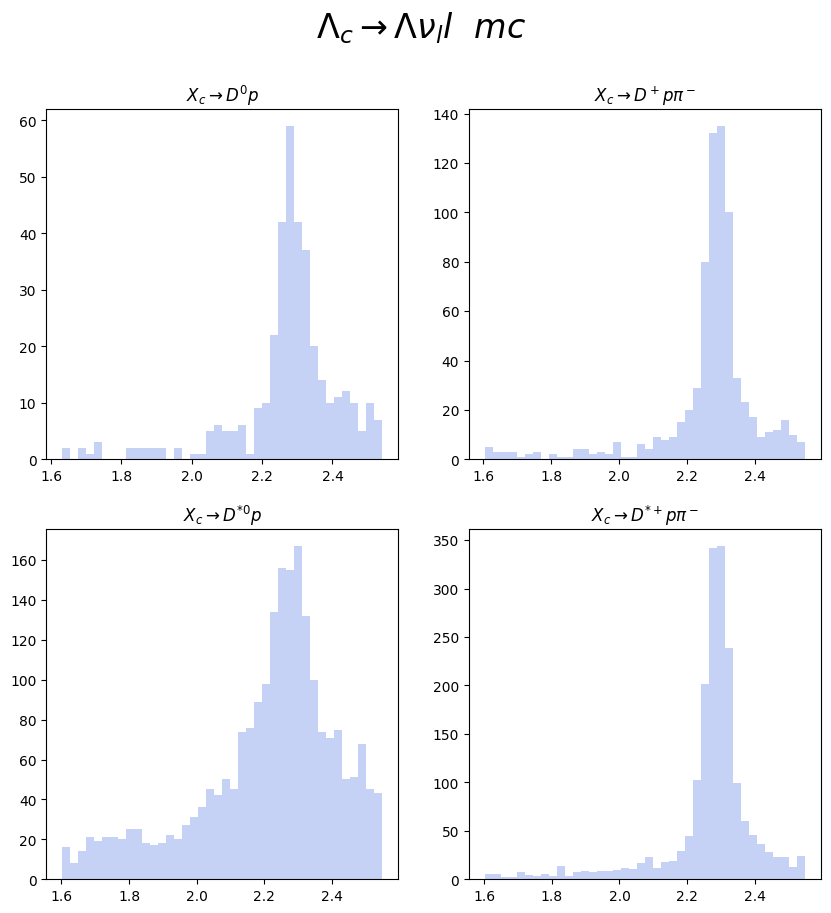

In [142]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2) & (1.6 <= (mc.rm2l)) & ((mc.rm2l) <= 2.55) & ((mc.rm2n) < 0.1)
    dat = mc[(mc.chxc == i + 1) & mask]

    axs[i//n, i%n].set_title(decay_mod_taging[i])

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=100)


fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l \\ \\  mc$", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml_lep.png")

In [84]:
sq = lambda x, c1: c1 * np.sqrt(np.abs(x - lamc_mass - pi_mass)) * np.heaviside(x - lamc_mass - pi_mass, 0)
continuum_lam = lambda x, c0, c1: c0*eval_chebyt(0, x) + quad(lambda x, s: sq(x - s, c1) +  )
signal_lam = lambda x, sigma1: gaussian(x, lamc_mass, sigma1)
f_lam = lambda x, A1, sigma1, c0, c1: A1*signal_lam(x, sigma1) + (1-A1)*continuum_lam(x, c0, c1)

/tmp/ipykernel_4045/84174007.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-x)*np.power(x, n)/gamma(n)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 107.22884016526743
             x: [ 4.228e-03  6.812e-02  5.283e-03  1.137e-01]
           nit: 211
          nfev: 386
 final_simplex: (array([[ 4.228e-03,  6.812e-02,  5.283e-03,  1.137e-01],
                       [ 4.228e-03,  6.812e-02,  5.283e-03,  1.137e-01],
                       ...,
                       [ 4.228e-03,  6.812e-02,  5.283e-03,  1.137e-01],
                       [ 4.228e-03,  6.812e-02,  5.283e-03,  1.137e-01]]), array([ 1.072e+02,  1.072e+02,  1.072e+02,  1.072e+02,
                        1.072e+02]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 125.5417416758011
             x: [ 1.405e-02  5.298e-02  1.494e-02  2.986e-01]
           nit: 221
          nfev: 389
 final_simplex: (array([[ 1.405e-02,  5.298e-02,  1.494e-02,  2.986e-01],
                       [ 1.405e-02,  5.298e-02,  1.4

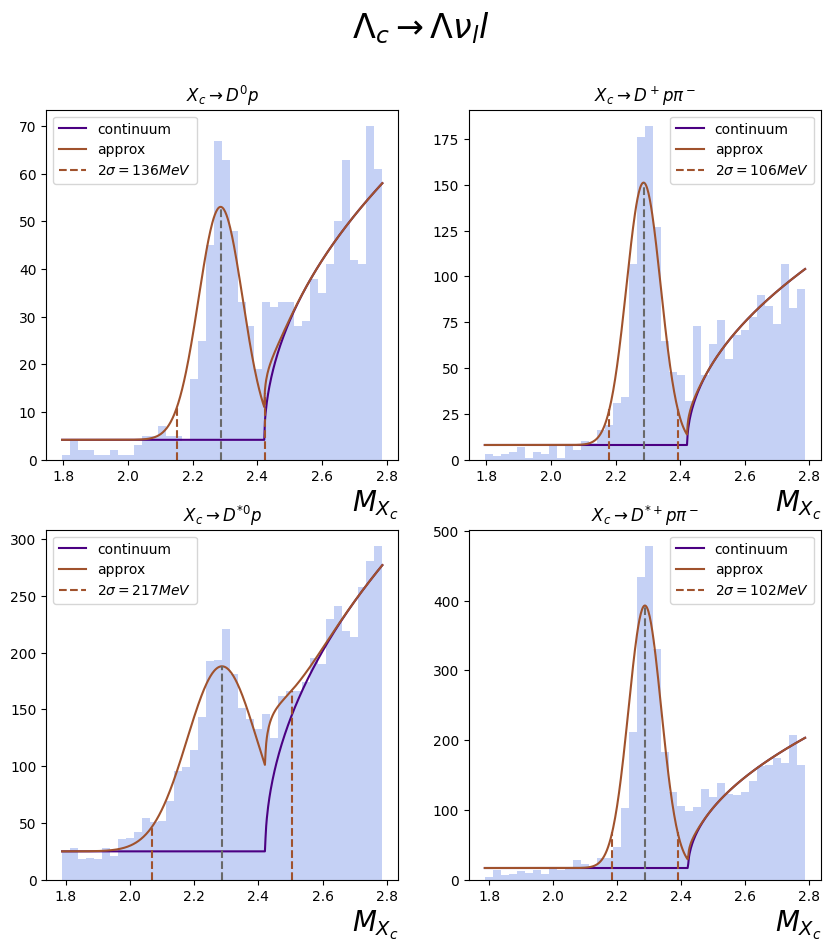

In [85]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 0.5) 
    dat = mc[(mc.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=100)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    args, normm = max_bin_lik(f_lam, bin_centers, counts, (0.5, 0.1, 0, 2), bounds=((0, 1), (0, 0.2), (0, 0.1), (-3, 3)))    
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[-2:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    sigmas_12.append(round(float(np.abs(args[1])), 6))

    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].vlines((lamc_mass-2*np.abs(args[1]),lamc_mass+2*np.abs(args[1])), (0, 0), 
                          (f_lam(lamc_mass-2*np.abs(args[1]), *args)*norm/normm, f_lam(lamc_mass+2*np.abs(args[1]), *args)*norm/normm), 
                          linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml_lep.png")

/tmp/ipykernel_4045/3059873438.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)


TypeError: <lambda>() takes 5 positional arguments but 6 were given

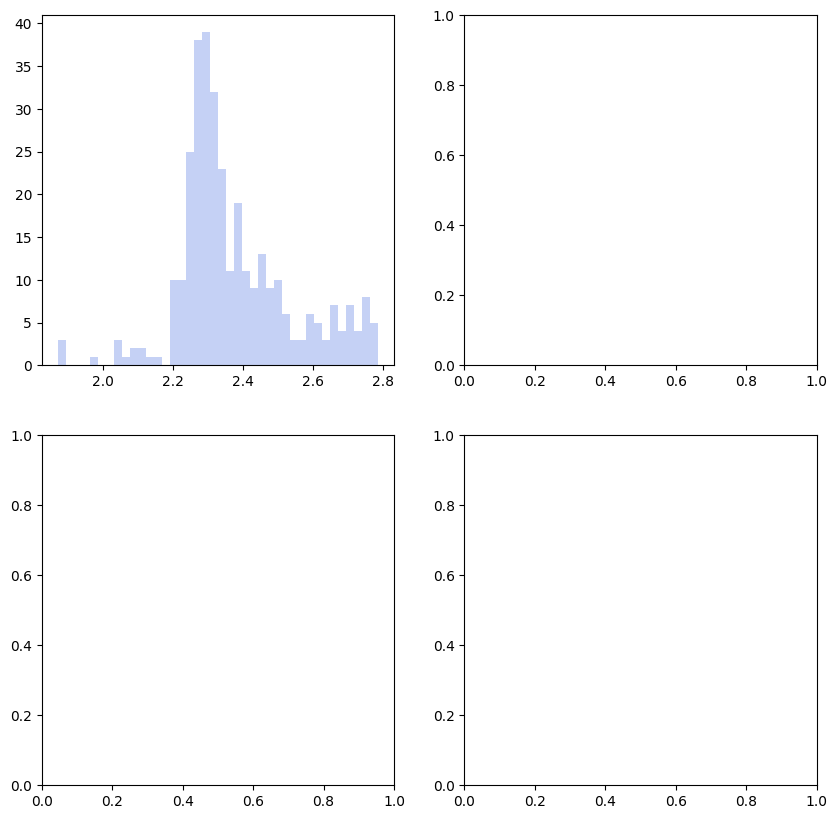

In [82]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 0.5) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.3) 
    dat = mc[(mc.chxc == i + 1) & (np.abs(mc.nrm2n) < 0.03) & (abs(mc.nrm2l-lamc_mass) < 0.5) & mask ]


    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=1000)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    args, normm = max_bin_lik(f_lam, bin_centers, counts, (0.5, 0.15, 0, 1, lamc_mass + pi_mass), bounds=((0, 1), (0, 0.2), (0, 0.1), (-2, 2), (lamc_mass + pi_mass-0.05, lamc_mass + pi_mass-0.05)))    
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[-3:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    sigmas_12.append(round(float(np.abs(args[1])), 6))

    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].vlines((lamc_mass-2*np.abs(args[1]),lamc_mass+2*np.abs(args[1])), (0, 0), 
                          (f_lam(lamc_mass-2*np.abs(args[1]), *args)*norm/normm, f_lam(lamc_mass+2*np.abs(args[1]), *args)*norm/normm), 
                          linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml_lep.png")

/tmp/ipykernel_22192/2666230078.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  rez = minimize(df, args0, args=(bin_centers, counts), method='Nelder-Mead', options={'xatol': h, 'fatol': h}, bounds=bounds)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 74.3819686286562
             x: [ 1.792e-03  3.433e-02  1.548e-02  2.162e-02  2.371e+00]
           nit: 331
          nfev: 564
 final_simplex: (array([[ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       ...,
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00]]), array([ 7.438e+01,  7.438e+01,  7.438e+01,  7.438e+01,
                        7.438e+01,  7.438e+01]))


/tmp/ipykernel_22192/84174007.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-x)*np.power(x, n)/gamma(n)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 83.9723732758508
             x: [ 1.879e-03  4.240e-02  4.492e-03  2.133e-02  2.371e+00]
           nit: 231
          nfev: 406
 final_simplex: (array([[ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       ...,
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00]]), array([ 8.397e+01,  8.397e+01,  8.397e+01,  8.397e+01,
                        8.397e+01,  8.397e+01]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 126.6384637090623
             x: [ 7.999e-02  1.076e-01  9.565e-02  1.069e+00  2.371e+00]
           nit: 46

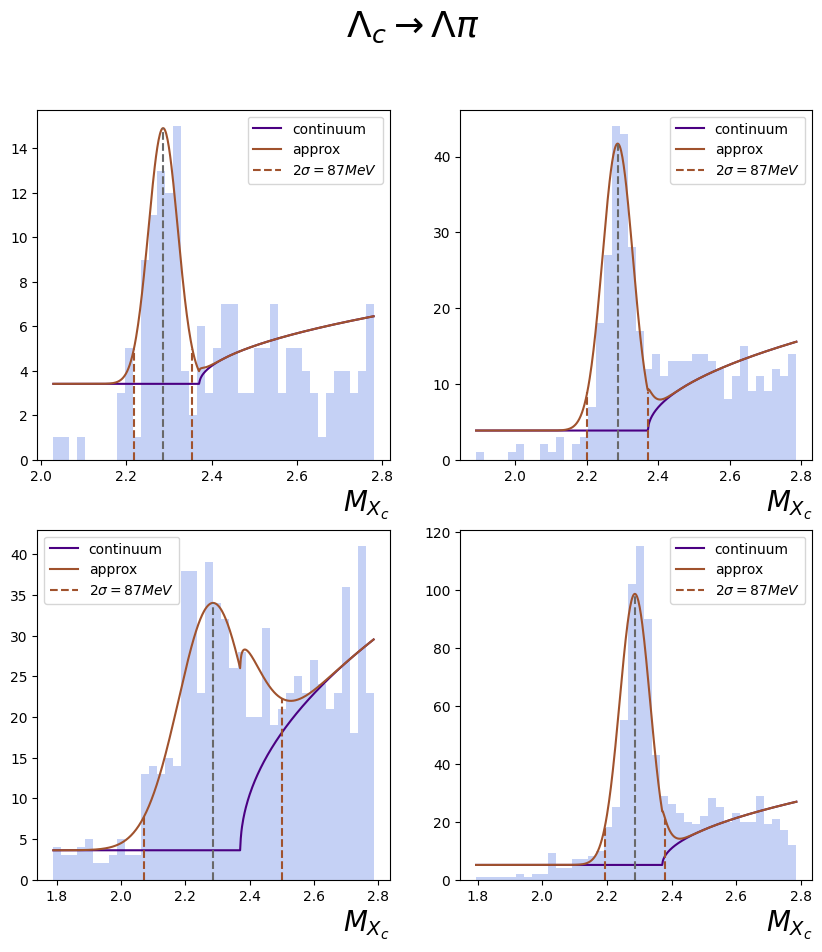

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_3 = list()

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 3)  & (np.abs(mc.rm2l - lamc_mass) < 0.5) & (np.abs(mc.nrm2n) < 0.1) 
    dat = mc[(mc.chxc == i + 1) & (np.abs(mc.nrm2n) < 5) & (abs(mc.nrm2l-lamc_mass) < 0.5) & mask]

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=100)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    args, normm = max_bin_lik(f_lam, bin_centers, counts, (0.5, 0.15, 0, 1, lamc_mass + pi_mass), bounds=((0, 1), (0, 0.2), (0, 0.1), (-2, 2), (lamc_mass + pi_mass-0.05, lamc_mass + pi_mass-0.05)))    
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[-3:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    sigmas_3.append(round(float(np.abs(args[1])), 6))


    axs[i//n, i%n].vlines((lamc_mass-2*np.abs(args[1]),lamc_mass+2*np.abs(args[1])), (0, 0), 
                          (f_lam(lamc_mass-2*np.abs(args[1]), *args)*norm/normm, f_lam(lamc_mass+2*np.abs(args[1]), *args)*norm/normm), 
                          linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\pi $", fontsize = 26)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml_pkpi.png")

<>:16: SyntaxWarning: invalid escape sequence '\L'
<>:16: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_6714/2074193042.py:16: SyntaxWarning: invalid escape sequence '\L'
  fig.suptitle("$\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when l

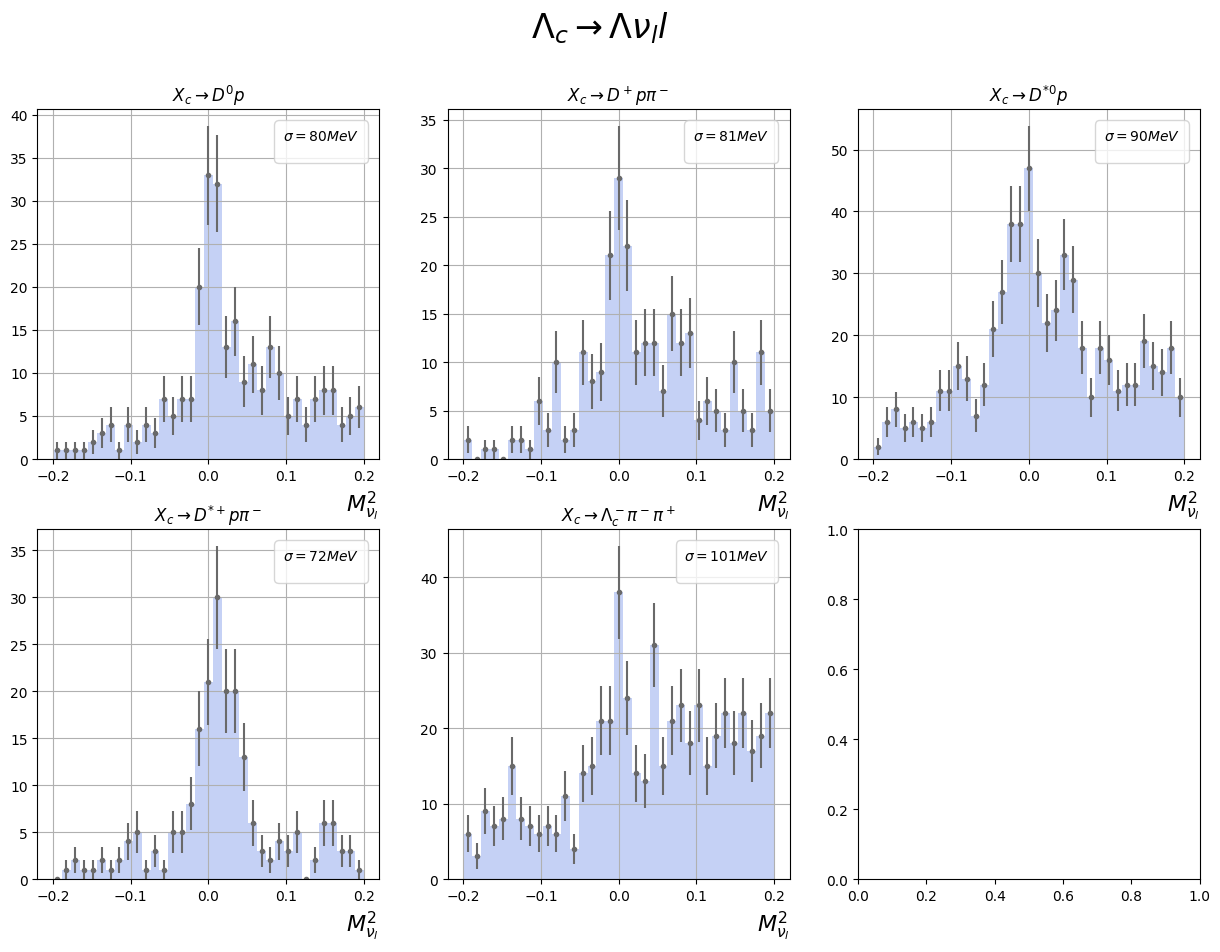

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.rm2n) < 0.2)
    counts, bin_edges, _ = axs[i//n, i%n].hist(mc[(mc.chxc == i + 1) & mask].rm2n, bins = nbins, range = (-0.2, +0.2), alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend(title=f'$\\sigma = {round(float(np.var(mc[(mc.chxc == i + 1) & mask].rm2n)**0.5*1000))} MeV$', fontsize=16)

fig.suptitle("$\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_bef.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


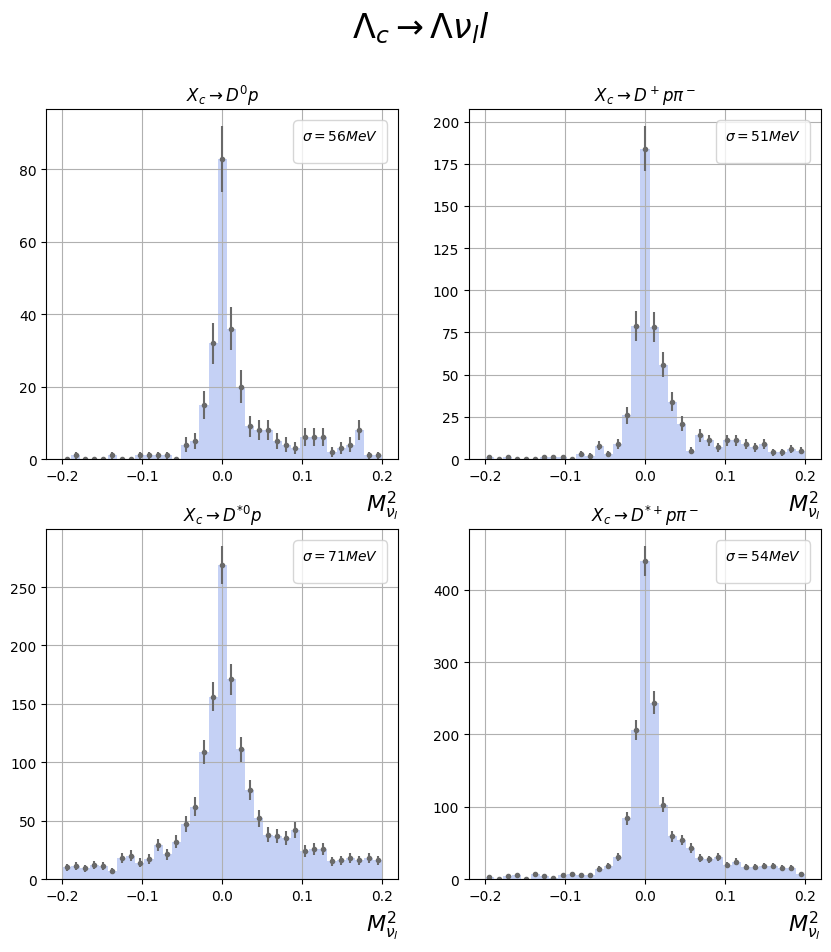

In [130]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.2)
    counts, bin_edges, _ = axs[i//n, i%n].hist(mc[(mc.chxc == i + 1) & mask].nrm2n, bins = nbins, range = (-0.2, +0.2), alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')   & mas
    axs[i//n, i%n].legend(title=f'$\\sigma = {round(float(np.var(mc[(mc.chxc == i + 1) & mask].nrm2n)**0.5*1000))} MeV$', fontsize=16)

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_aft.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


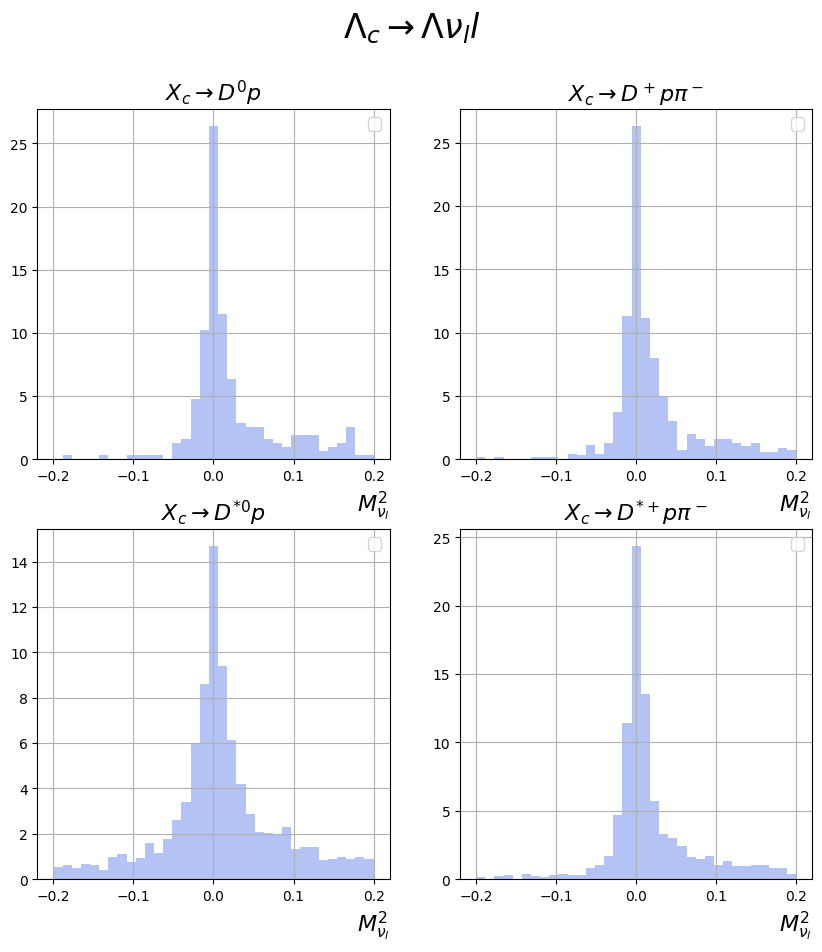

In [142]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 3) & (np.abs(mc.nrm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) &  (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i])
    dat = mc[(mc.chxc == i + 1) & (np.abs(mc.nrm2n) < 0.2) & mask]
    axs[i//n, i%n].hist(dat.nrm2n, bins = nbins, alpha = 0.4, color = "royalblue", range = (-0.2, +0.2), density = True)
    axs[i//n, i%n].hist(dat[(dat.tr_p == 1) & (dat.tr_ach == 1) & (dat.tr_lamc == 1)].nrm2n, bins = nbins, alpha = 0.4, density = True, color = "dimgrey", range = (-0.2, +0.2))
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')   & mas
    axs[i//n, i%n].legend(fontsize=12)

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_both.png")

In [ ]:
continuum = lambda x, c0, c1, c2: c0*eval_chebyt(0, x) + c1*eval_chebyt(1, x) + c2*eval_chebyt(2, x)
sigmal_n = lambda x, A1, sigma1: A1*gaussian(x, 0, sigma1)
f_n = lambda x, A1, sigma1, c0, c1, c2: sigmal_n(x, A1, sigma1) + continuum(x, c0, c1,  c2)

126
100
269
104
62


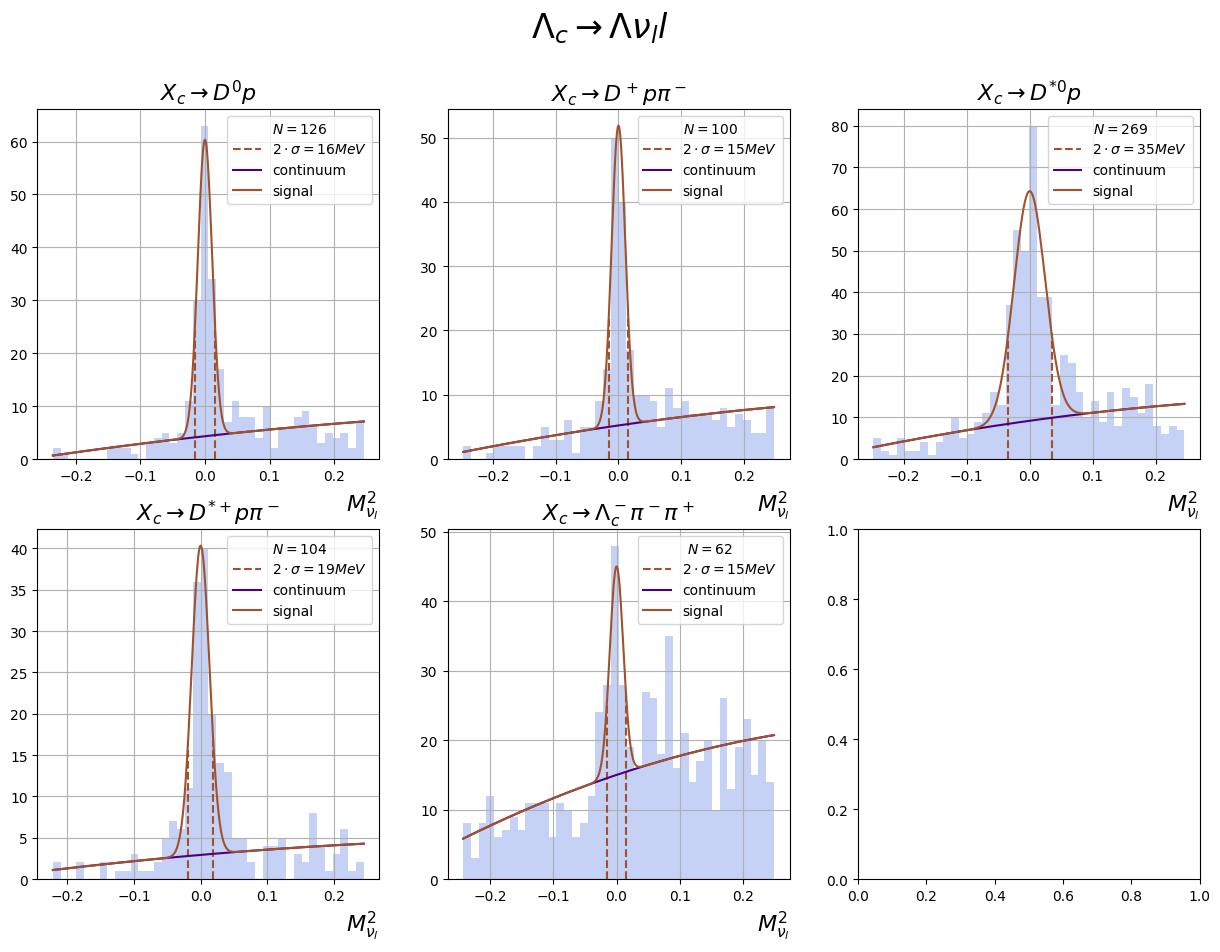

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
sig_n = list()
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25)
    _ = mc[(mc.chxc == i + 1) & mask]
    norm = _.nrm2n.shape[0]

    counts, bin_edges, _ = axs[i//n, i%n].hist(_.nrm2n, bins = nbins, 
                            alpha = 0.3, color = "royalblue")

    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    args, covar = curve_fit(f_n, bin_centers, counts/norm, bounds = ([-np.inf, 0, 0, 0, -1], [np.inf, 0.05, 1, 1, 1]))

    xx = np.linspace(-3, 3, 50000)
    sig_n.append(args[1])
    s = 2*sig_n[-1]
    axs[i//n, i%n].vlines((-s,s), (0, 0), (f_n(-s, *args)*norm, f_n(s, *args)*norm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\cdot \\sigma = {round(s*1000)} MeV$")

    axs[i//n, i%n].plot(x, continuum(x, *args[-3:])*norm, color = 'indigo', label =  "continuum")
    axs[i//n, i%n].plot(x, f_n(x, *args)*norm, color = 'sienna', label = "signal")
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')

    N = np.sum(sigmal_n(bin_centers, *args[:2])*norm, dtype=int)
    axs[i//n, i%n].legend(title=f'$N = {N}$')
    print(N)
fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_lept.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_mc.png")

In [ ]:
continuum = lambda x, c0, c1, c2: c0*eval_chebyt(0, x) + c1*eval_chebyt(1, x) + c2*eval_chebyt(2, x)
sigmal_n = lambda x, A1, sigma1: A1*gaussian(x, 0, sigma1)
f_n = lambda x, A1, sigma1, mu, c0, c1, c2: (sigmal_n(x, A1, sigma1) + continuum(x, c0, c1, c2)) * np.heaviside(-(x-mu), 1)

$X_c \to D^0 p$ 152
$X_c \to D^+ p \pi^- $ 156
$X_c \to D^{*0} p$ 329
$X_c \to D^{*+} p \pi^-$ 108
$X_c \to \Lambda_c^- \pi^- \pi^+$ 123
[0.007820541712490466, 0.007709247886032468, 0.017483345498215473, 0.00942932826794022, 0.007564345997453639]


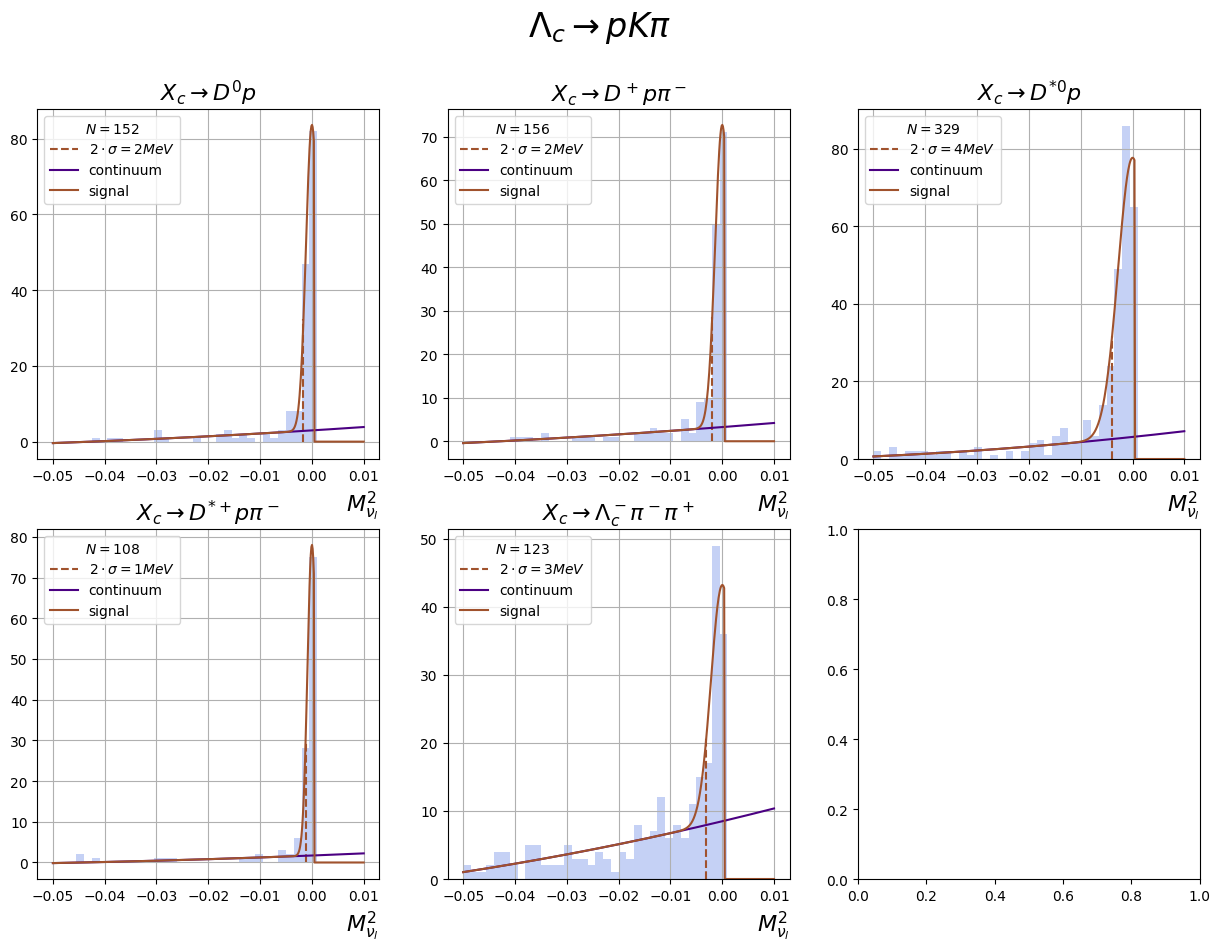

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 5)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_5[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25)
    _ = mc[(mc.chxc == i + 1) & mask]
    norm = _.nrm2n.shape[0]

    counts, bin_edges, _ = axs[i//n, i%n].hist(_.nrm2n, bins = nbins,  range = (-0.05, 0.01),
                            alpha = 0.3, color = "royalblue")

    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    args, covar = curve_fit(f_n, bin_centers, counts/norm, bounds = ([-np.inf, 0, -0.001, 0, 0, -1], [np.inf, 0.05, 0.002, 1, 1, 1]))

    xx = np.linspace(-3, 3, 50000)
    s = 2*args[1]
    axs[i//n, i%n].vlines((-s,s), (0, 0), (f_n(-s, *args)*norm, f_n(s, *args)*norm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\cdot \\sigma = {round(s*1000)} MeV$")

    axs[i//n, i%n].plot(x, continuum(x, *args[-3:])*norm, color = 'indigo', label =  "continuum")
    axs[i//n, i%n].plot(x, f_n(x, *args)*norm, color = 'sienna', label = "signal")
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')

    N = np.sum(sigmal_n(bin_centers, *args[:2])*norm, dtype=int)
    print(decay_mod_taging[i], N)
    axs[i//n, i%n].legend(title=f'$N = {N}$')
print(sig_n)
fig.suptitle("$\\Lambda_c \\to p K \\pi$", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_pkpi.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_mc.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


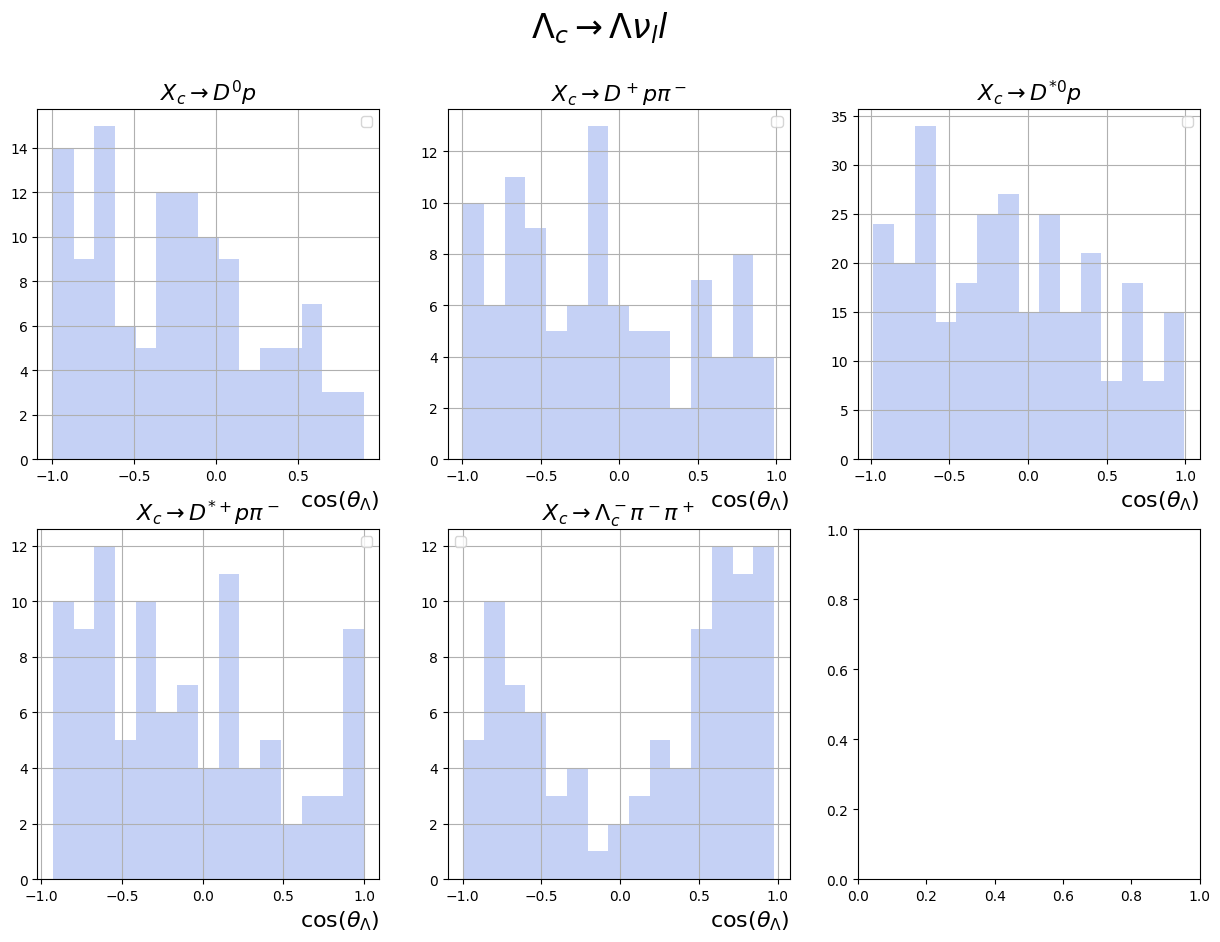

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 15

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2) & (mc.ml < 0) & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (np.abs(mc.nrm2n) < 2*sig_n[i])
    _ = mc[(mc.chxc == i + 1) & mask]

    axs[i//n, i%n].hist(np.cos(_.ang_lc_l), bins = nbins, alpha = 0.3, color = "royalblue")
    #axs[i//n, i%n].hist(np.cos(_.ang_lc_l), bins = nbins, alpha = 0.3, color = "dimgrey")
    #axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$\\cos(\\theta_{\\Lambda})$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//ang_lc_l.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


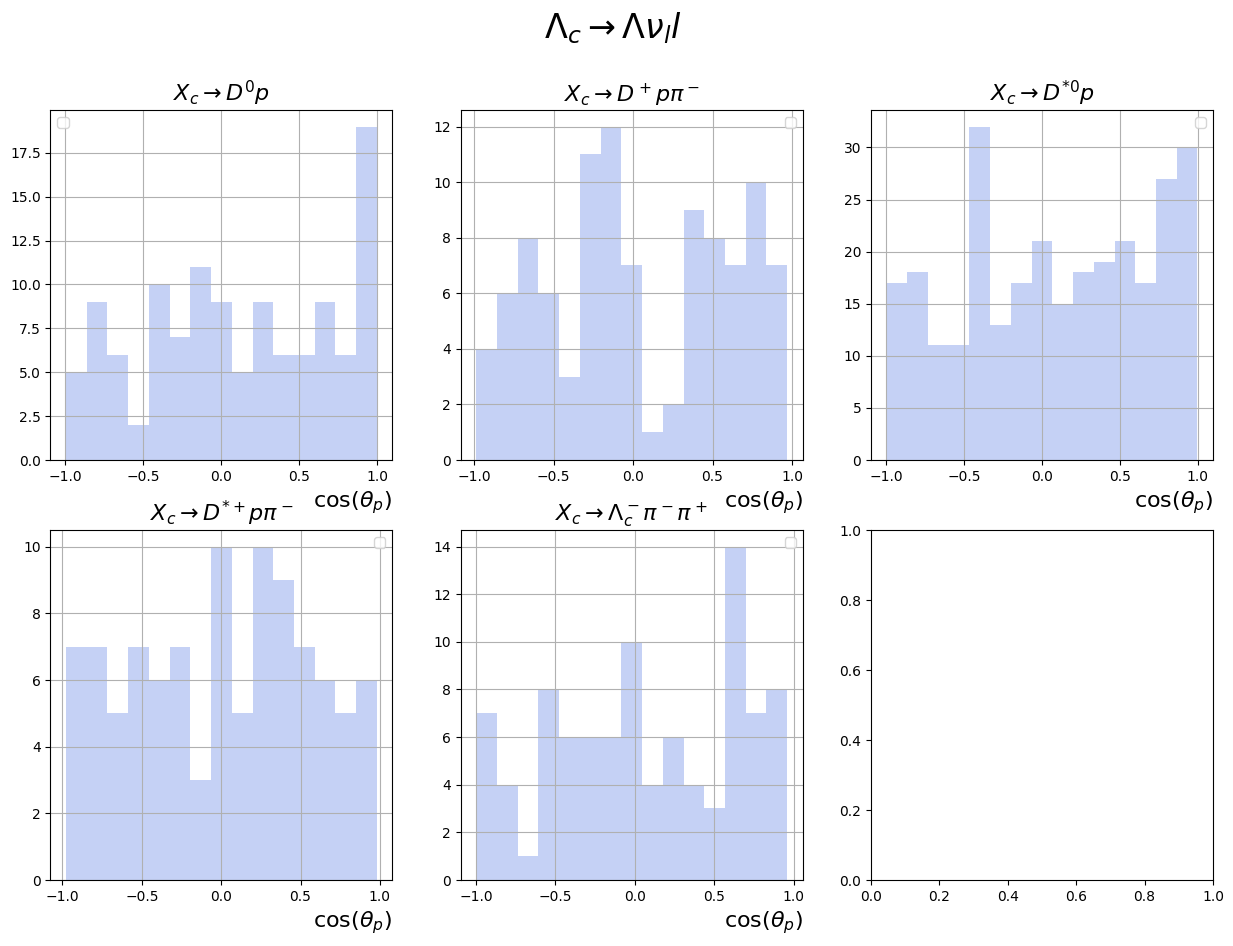

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 15

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25) & (np.abs(mc.nrm2n) < 2*sig_n[i])
    _ = mc[(mc.chxc == i + 1) & mask]

    counts, bin_edges, _ = axs[i//n, i%n].hist(np.cos(_.ang_l_p), bins = nbins, alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$\\cos(\\theta_{p})$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//ang_l_p.png")